# Experimental Design
***
## Optimising underlayers

Import the neccesary libraries

In [ ]:
%matplotlib inline

from hogben.models.samples import Sample

from hogben.optimise import Optimiser
from hogben.utils import Fisher
from refnx.reflect import SLD

import matplotlib.pyplot as plt

def refnx_sample():
    """Define a bilayer sample, and return the associated refnx model"""
    # Define sample
    air = SLD(0, name='Air')
    layer1 = SLD(4, name='Layer 1')(thick=45, rough=8)
    layer2 = SLD(6, name='Layer 2')(thick=25, rough=8)
    layer3 = SLD(3, name='Layer 3')(thick=80, rough=7)
    substrate = SLD(2.047, name='Substrate')(thick=0, rough=5)

    layer1.thick.bounds = (20, 60)
    layer2.thick.bounds = (10, 30)
    layer3.thick.bounds = (40, 100)
    layer1.rough.bounds = (4, 10)
    layer2.rough.bounds = (4, 10)
    layer3.rough.bounds = (4, 10)

    params = [
        layer1.thick,
        layer2.thick,
        layer1.rough,
        layer2.rough,
        layer3.rough,
        layer3.thick,
    ]
    for param in params:
        param.vary = True

    layer3.underlayer = True
    sample = air  | layer1 | layer2 | layer3 | substrate
    return sample

model = refnx_sample()

Create a new sample:

In [ ]:
sample = Sample(model)

Optimise



In [ ]:
# Number of points and counting times for each angle to simulate.
angle_times = [(0.7, 100, 10),
               (2.3, 100, 40)]
thick_bounds = (1, 150)
sld_bounds = (1, 7)

conditions = {"thick_bounds": thick_bounds,
              "sld_bounds": sld_bounds,
              "angle_times": angle_times}

sample = Sample(model)
optimiser = Optimiser(sample)
thicknesses, slds, val = \
    optimiser.optimise_underlayer_experiment(sample, conditions,
                                             verbose=False)
print(thicknesses)
print(slds)

In [ ]:

thick_range = thick_bounds[1] - thick_bounds[0]
sld_range = sld_bounds[1] - sld_bounds[0]

eigenval = []
thicknessrange = []

i = 0

for layer in sample.structure:
    if hasattr(layer, 'underlayer') and layer.underlayer:
        layer.thick.value = thicknesses[i]
        layer.sld.real.value = slds[i]

        for j in range(150):
            thick = (thick_range/150)*j + thick_bounds[0]
            thicknessrange.append(thick)
            layer.thick.value = thick
            min_eigenval = Fisher.from_sample(sample, angle_times).min_eigenval
            eigenval.append(min_eigenval)
        i += 1


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(thicknessrange, eigenval)
ax.set_xlabel('Underlayer thickness (Å)', fontsize = 14)
ax.set_ylabel('Minimum Eigenvalue', fontsize = 14)
plt.show()

eigenval = []
sldarray = []

i = 0
for layer in sample.structure:
    if hasattr(layer, 'underlayer') and layer.underlayer:
        layer.thick.value = thicknesses[i]
        layer.sld.real.value = slds[i]

        for j in range(150):
            sld = (sld_range/150)*j + sld_bounds[0]
            sldarray.append(sld)
            layer.sld.real.value = sld
            min_eigenval = Fisher.from_sample(sample, angle_times).min_eigenval
            eigenval.append(min_eigenval)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sldarray, eigenval)
ax.set_xlabel('SLD Value (10$^{-6}$ Å$^{-2})$', fontsize = 14)
ax.set_ylabel('Minimum Eigenvalue ', fontsize = 14)
plt.show()
plt.savefig("sld.png")

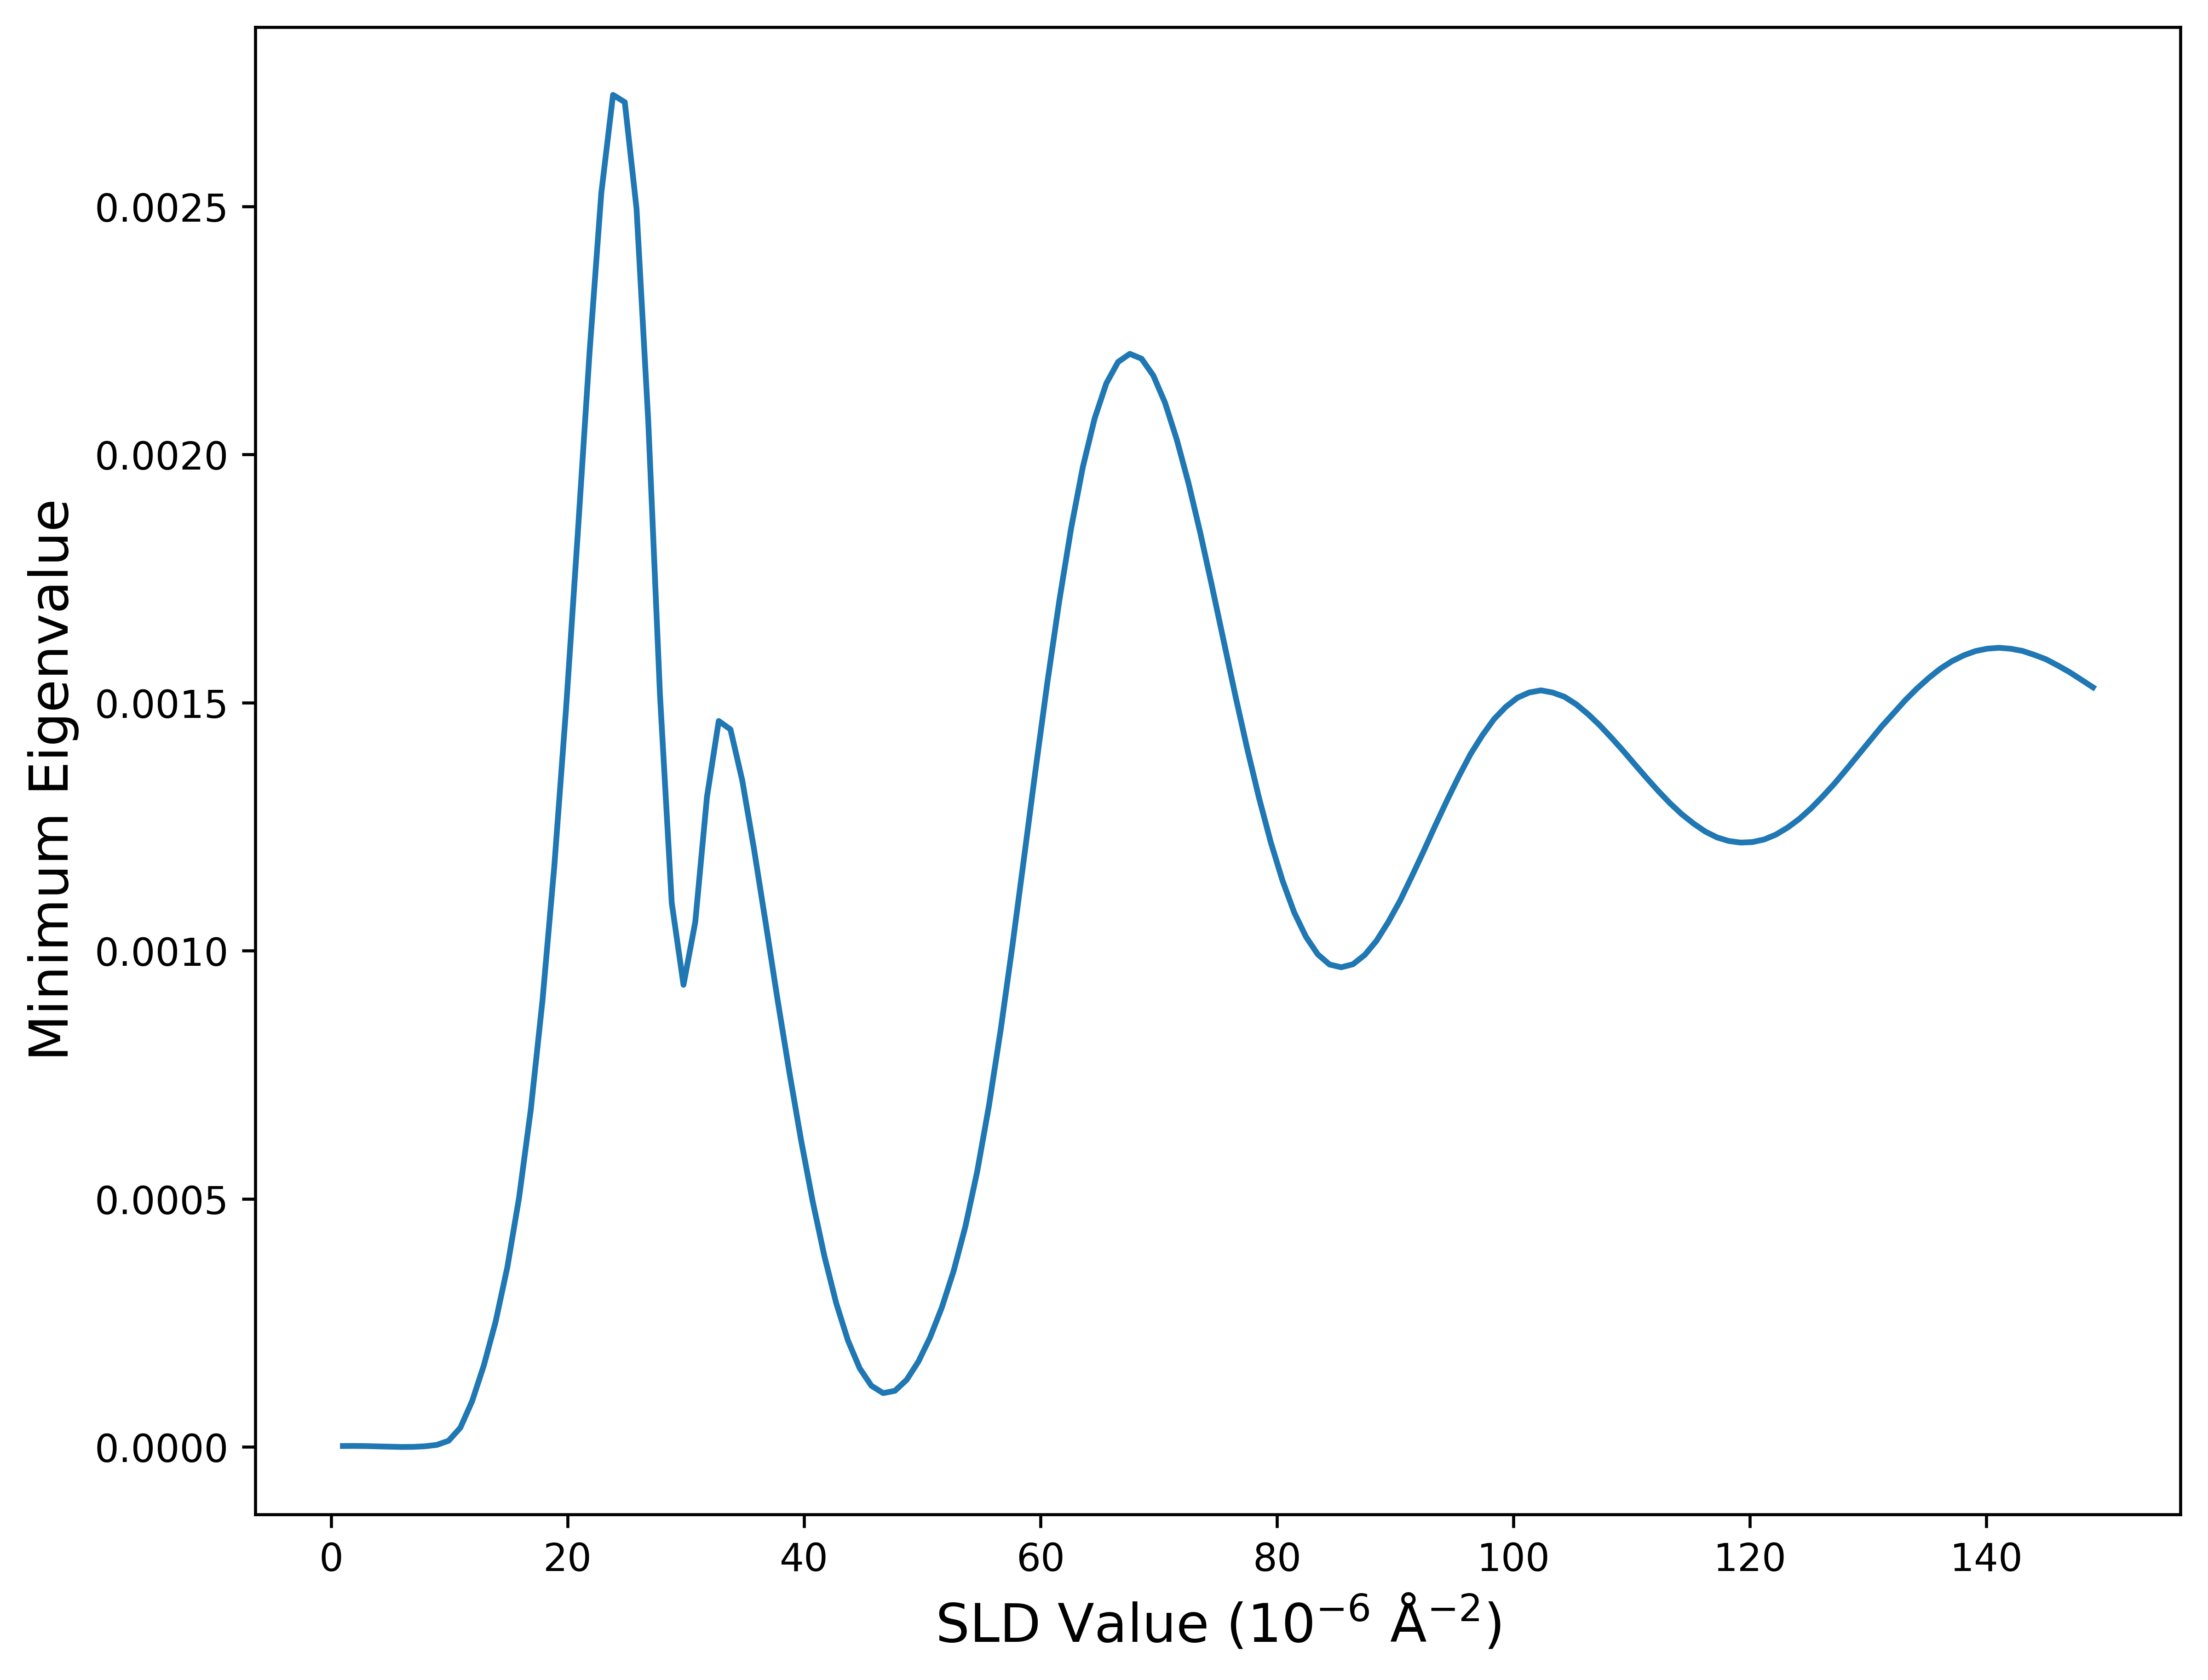

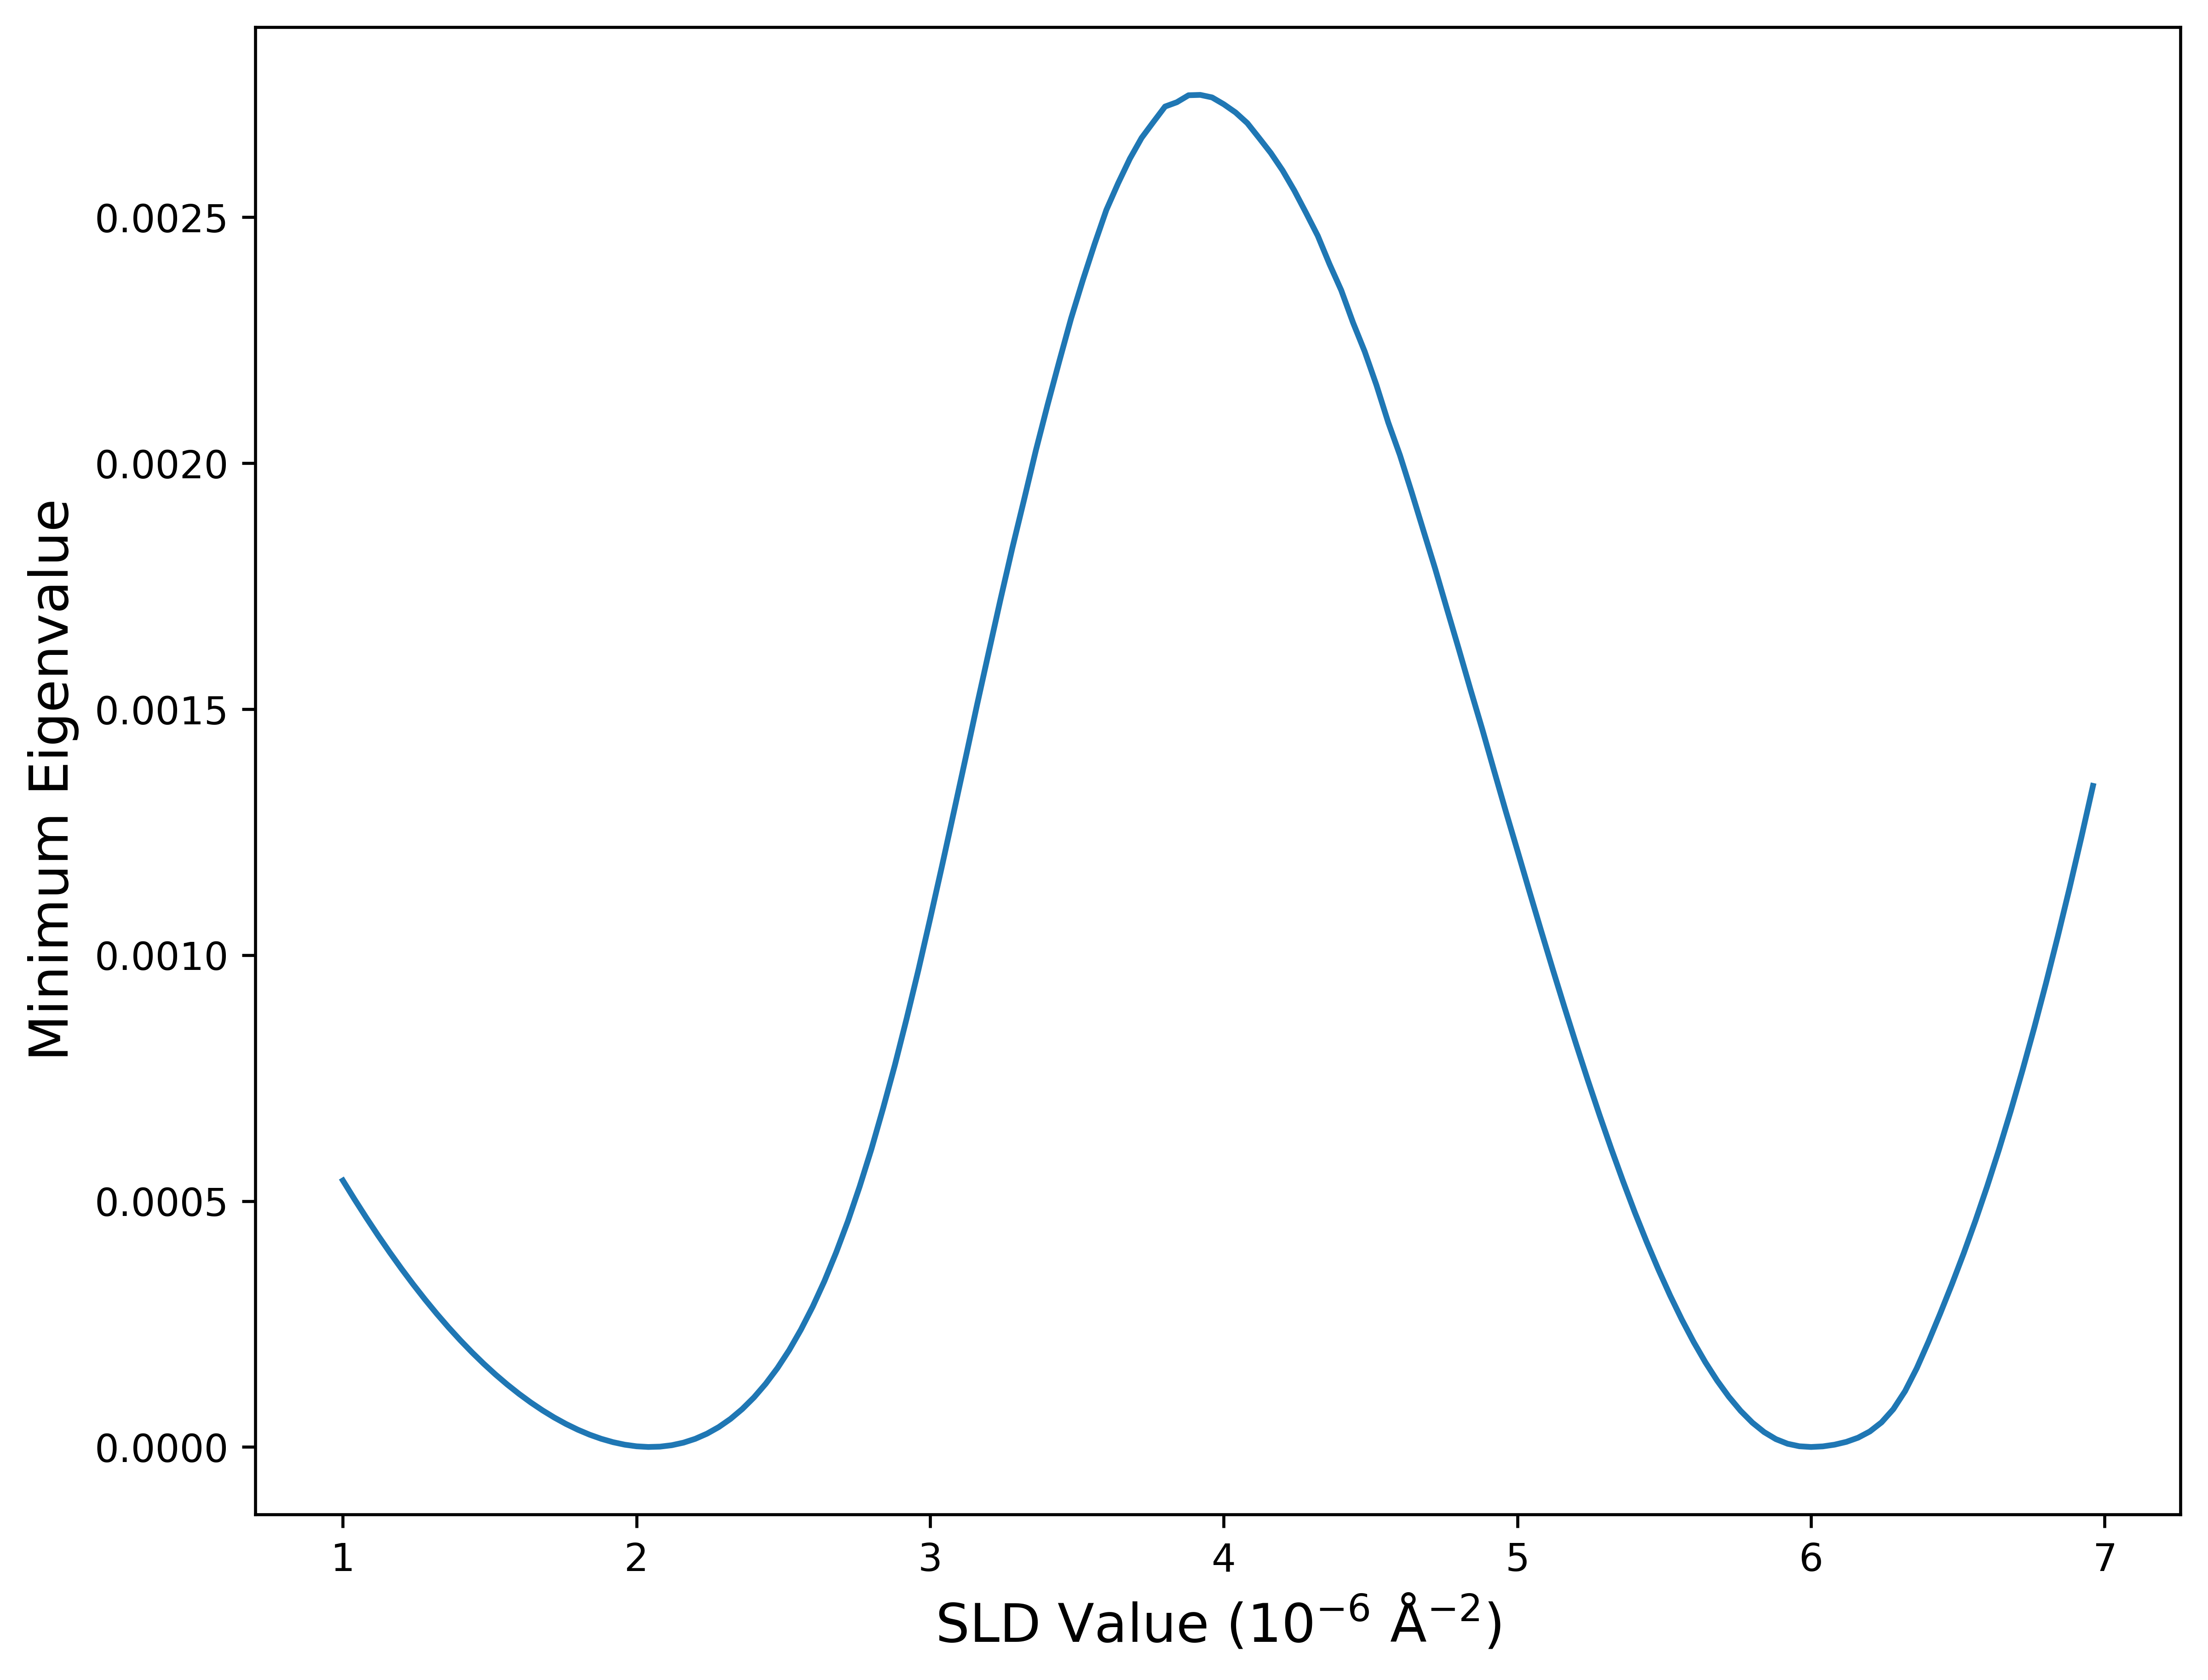

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [9]:
for condition, values in conditions.items():
    eigenval = []
    values_array = []
    value_range = values[1] - values[0]
    i = 0
    for layer in sample.structure:
        if condition == "angle_times":
            continue
        if hasattr(layer, 'underlayer') and layer.underlayer:
            layer.thick.value = thicknesses[i]
            layer.sld.real.value = slds[i]
            for j in range(150):
                value = (value_range/150)*j + values[0]
                values_array.append(value)
                if condition == "thick_bounds":
                    layer.thick.value = value
                    xlabel = 'Underlayer thickness (Å)'
                elif condition == "sld_bounds":
                    layer.sld.real.value = value
                    xlabel = 'SLD Value (10$^{-6}$ Å$^{-2})$'
                min_eigenval = Fisher.from_sample(sample, angle_times).min_eigenval
                eigenval.append(min_eigenval)
            i += 1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(values_array, eigenval)
    ax.set_xlabel('SLD Value (10$^{-6}$ Å$^{-2})$', fontsize = 14)
    ax.set_ylabel('Minimum Eigenvalue ', fontsize = 14)
    plt.show()